**About Dataset**


70000 records and 13 feature columns



Content<br>
The features are given below:<br>
Age | Objective Feature | age | int (days)<br>
Height | Objective Feature | height | int (cm) |<br>
Weight | Objective Feature | weight | float (kg) |<br>
Gender | Objective Feature | gender | categorical code |<br>
Systolic blood pressure | Examination Feature | ap_hi | int |<br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary |<br>
Alcohol intake | Subjective Feature | alco | binary |<br>
Physical activity | Subjective Feature | active | binary |<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

df=pd.read_csv("heart_data.csv")
df.head(5)

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [44]:
#Checking for any null values
print(df.isnull().sum())

index          0
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [3]:
#Converting age in days to age in yrs
df['age'] = np.floor(df['age'] / 365.25).astype(int)
#Creating BMI column using existing weight(Kg) and height(cm) column
df['BMI'] = df['weight'] / ((df['height']/100) ** 2)

df.head(5)

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


Creating a column for hypertension and categorizing people

In [11]:
def classify_blood_pressure(row):
    systolic = row['ap_hi']
    diastolic = row['ap_lo']

    if systolic < 120 and diastolic < 80:
        return 0
    elif 120 <= systolic <= 129 and diastolic < 80:
        return 1
    elif 130 <= systolic <= 139 or (80 <= diastolic <= 89):
        return 2
    elif 179 >= systolic >= 140 or 119 >= diastolic >= 90:
        return 3
    elif systolic >= 180 or diastolic >= 120:
        return 4

# adding hypertension column
df['Hypertension'] = df.apply(classify_blood_pressure, axis=1)
print(df.head(10))

   index  id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0      0   0   50       2     168    62.0    110     80            1     1   
1      1   1   55       1     156    85.0    140     90            3     1   
2      2   2   51       1     165    64.0    130     70            3     1   
3      3   3   48       2     169    82.0    150    100            1     1   
4      4   4   47       1     156    56.0    100     60            1     1   
5      5   8   59       1     151    67.0    120     80            2     2   
6      6   9   60       1     157    93.0    130     80            3     1   
7      7  12   61       2     178    95.0    130     90            3     3   
8      8  13   48       1     158    71.0    110     70            1     1   
9      9  14   54       1     164    68.0    110     60            1     1   

   smoke  alco  active  cardio        BMI  Hypertension  
0      0     0       1       0  21.967120             2  
1      0     0       1   

In [12]:
#Checking for neg values in datasets
def check_neg(column_to_check):
  negative_count = (df[column_to_check] < 0).sum()
  print("Count of negative values in column '{}': {}".format(column_to_check, negative_count))

for col in df.columns:
  check_neg(col)

Count of negative values in column 'index': 0
Count of negative values in column 'id': 0
Count of negative values in column 'age': 0
Count of negative values in column 'gender': 0
Count of negative values in column 'height': 0
Count of negative values in column 'weight': 0
Count of negative values in column 'ap_hi': 7
Count of negative values in column 'ap_lo': 1
Count of negative values in column 'cholesterol': 0
Count of negative values in column 'gluc': 0
Count of negative values in column 'smoke': 0
Count of negative values in column 'alco': 0
Count of negative values in column 'active': 0
Count of negative values in column 'cardio': 0
Count of negative values in column 'BMI': 0
Count of negative values in column 'Hypertension': 0


In [48]:
#sorting the df acc to age
df.sort_values(by='age', ascending=True, inplace=True)

#interpolate the negative ap_lo and ap_high with previous person who has similar age
df['ap_lo'] = df['ap_lo'].mask(df['ap_lo'] < 0, other=pd.NA)
df['ap_hi'] = df['ap_hi'].mask(df['ap_hi'] < 0, other=pd.NA)

df['ap_lo'] = df.groupby('age')['ap_lo'].transform(lambda x: x.interpolate(method='nearest'))
df['ap_hi'] = df.groupby('age')['ap_hi'].transform(lambda x: x.interpolate(method='nearest'))


for col in df.columns:
  check_neg(col)

Count of negative values in column 'index': 0
Count of negative values in column 'id': 0
Count of negative values in column 'age': 0
Count of negative values in column 'gender': 0
Count of negative values in column 'height': 0
Count of negative values in column 'weight': 0
Count of negative values in column 'ap_hi': 0
Count of negative values in column 'ap_lo': 0
Count of negative values in column 'cholesterol': 0
Count of negative values in column 'gluc': 0
Count of negative values in column 'smoke': 0
Count of negative values in column 'alco': 0
Count of negative values in column 'active': 0
Count of negative values in column 'cardio': 0
Count of negative values in column 'BMI': 0
Count of negative values in column 'Hypertension': 0


In [49]:
#unique value
print(df.nunique())

index           70000
id              70000
age                28
gender              2
height            109
weight            287
ap_hi             148
ap_lo             156
cholesterol         3
gluc                3
smoke               2
alco                2
active              2
cardio              2
BMI              3808
Hypertension        5
dtype: int64


**Analysis of datasets**

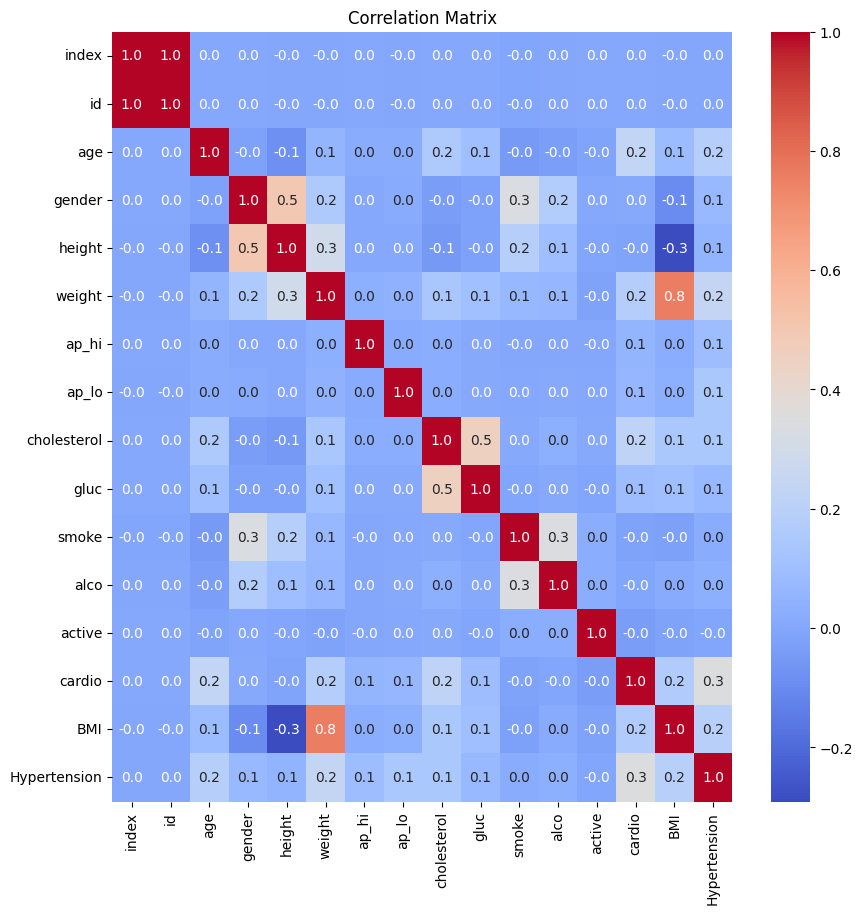

In [15]:
#Creating correlation matrix to measure statistical dependence of each feature.
correlation_matrix = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Matrix')
plt.show()

**Key Insights:**


*  ap_hi and ap_lo (Blood Pressure): These two variables have a perfect correlation (1.0), because they both represent blood pressure readings. This suggest that including both may lead to redundancy in the model; so we have consider to combine them in some meaningful way.
*  weight and BMI: There’s a strong positive correlation (0.8), as BMI is directly calculated using weight and height. This shows that weight is a significant determinant of BMI.
*  cholesterol and gluc (Blood Glucose): There’s a moderate positive correlation (0.5), indicating that high cholesterol is often associated with higher blood glucose levels, which is consistent with known cardiovascular risk factors. Both of these could be important for predicting cardiovascular disease.
*  gender and height: There is a noticeable correlation between gender and height (0.5). This might be due to biological differences in average heights between genders but may not be directly relevant to cardiovascular disease prediction.
*  height and BMI: There is a weak negative correlation (-0.3) between height and BMI. This relationship suggests that, on average, taller individuals may have slightly lower BMI values for a given weight compared to shorter individuals. Although weak, this negative correlation reflects that height inversely affects BMI when weight remains constant.



<Axes: ylabel='count'>

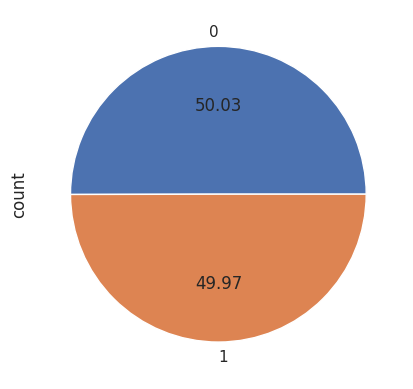

In [51]:
df['cardio'].value_counts().plot(kind='pie',autopct='%.2f')

**Key Insights:**

With approximately 49.97% of individuals with cardiovascular conditions or high cardiovascular risk, indicates a fairly balanced distribution between those at risk and those not at risk.So this dataset has a  balanced target variable which can be advantageous in predictive modeling as it reduces the risk of bias toward one class over the other.

<Axes: ylabel='count'>

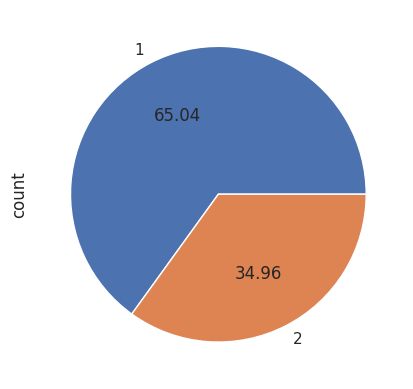

In [52]:
df['gender'].value_counts().plot(kind='pie',autopct='%.2f')

**Key Insights:**

The above pie chart is a skewed gender distribution, with a significantly higher proportion of males. This skewed ratio can impact the interpretation of risk factors, as certain cardiovascular risk factors may differ. For instance, lifestyle or biological factors might make some features more relevant predictors for one gender compared to the other.

(array([4.0000e+00, 6.7230e+03, 1.4930e+04, 2.4622e+04, 2.3721e+04]),
 array([29., 36., 43., 50., 57., 64.]),
 <BarContainer object of 5 artists>)

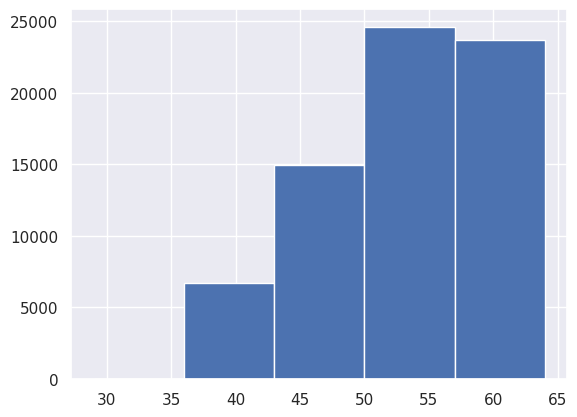

In [53]:
plt.hist(df['age'],bins=5)

**Key Insight:**

This plot shows the distribution of ages (in years). It shows that most individuals in the dataset are in the age range of around 50 to 65, with a lower number of individuals in the younger age brackets. This suggests a dataset skewed towards older adults, which might be relevant for the analysis involves age-related health or lifestyle trends.

C:\Users\divya\AppData\Local\Temp\ipykernel_976\974756348.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['alco'].mean().reset_index()


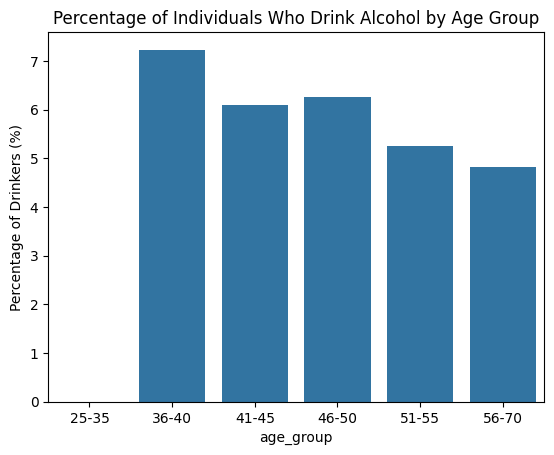

In [16]:
bins = [25, 35, 40, 45, 50, 55, 70]
labels = ['25-35', '36-40', '41-45', '46-50', '51-55', '56-70']

# Create a new column for age groups
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Calculate the percentage of drinkers by age group
percentage_df = df.groupby('age_group')['alco'].mean().reset_index()
percentage_df['percentage'] = percentage_df['alco'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of Drinkers (%)')
plt.title('Percentage of Individuals Who Drink Alcohol by Age Group')
plt.show()

**Insight:**

This bar chart shows that the highest percentage of alcohol consumption occurs in the 36-40 age group. After this peak, alcohol consumption percentage tends to decrease with age. This imply that middle-aged adults are more likely to consume alcohol than older age groups. Understanding this pattern can be valuable in studies related to alcohol's impact on health across different age ranges.

C:\Users\divya\AppData\Local\Temp\ipykernel_976\1568024372.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['smoke'].mean().reset_index()


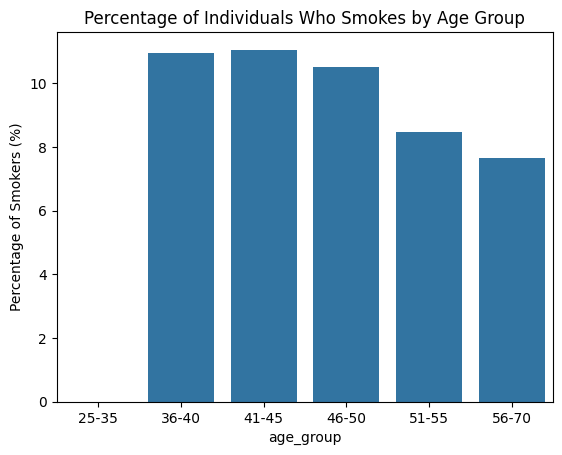

In [17]:
# Calculate the percentage of smokers by age group
percentage_df = df.groupby('age_group')['smoke'].mean().reset_index()
percentage_df['percentage'] = percentage_df['smoke'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of Smokers (%)')
plt.title('Percentage of Individuals Who Smokes by Age Group')
plt.show()

**Insight:**

 Individuals belonging to the age group 36-40 are constitute the highest percentage of smokers and alcohol drinkers. This is likely due to greater amount of stess levels that individuals at this age group are exposed to, which leads to them relying on external stimulants as stress relievers. Such individuals are at a risk for CVD in the next few years depending on the level of their consumption.

C:\Users\divya\AppData\Local\Temp\ipykernel_976\221444656.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['cholesterol'].mean().reset_index()


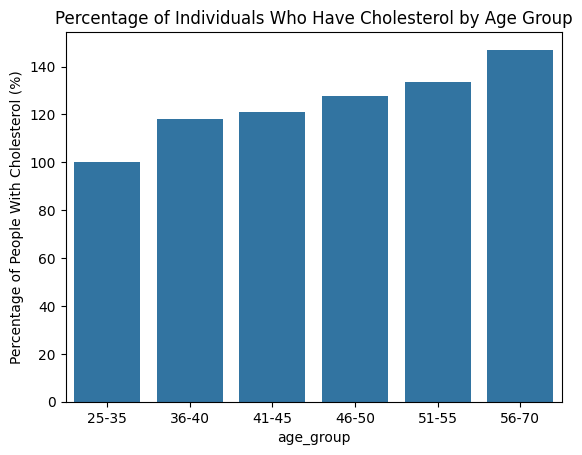

In [18]:
# Calculate the percentage of Cholestrol by age group
percentage_df = df.groupby('age_group')['cholesterol'].mean().reset_index()
percentage_df['percentage'] = percentage_df['cholesterol'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of People With Cholesterol (%)')
plt.title('Percentage of Individuals Who Have Cholesterol by Age Group')
plt.show()

**Insight:**

There is a steady increase in the cholestrol level of individuals as the age group is increasing, which ultimately increases their risk of getting CVD.

<ipython-input-57-cc65205821b1>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['active'].mean().reset_index()


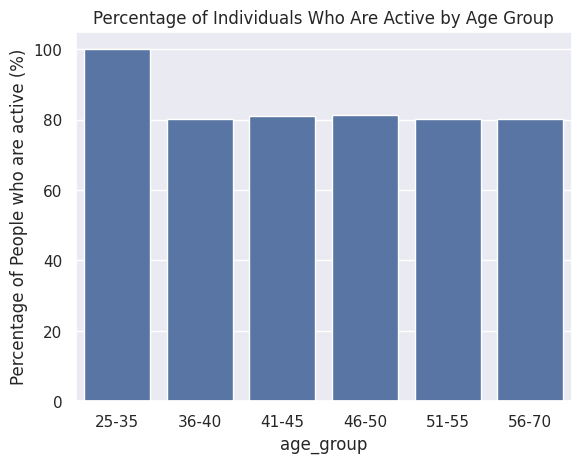

In [57]:
# Calculate the percentage of drinkers by age group
percentage_df = df.groupby('age_group')['active'].mean().reset_index()
percentage_df['percentage'] = percentage_df['active'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of People who are active (%)')
plt.title('Percentage of Individuals Who Are Active by Age Group')
plt.show()
df.drop(['age_group'], axis=1,inplace=True)

**Insight:**

It is observed that the younger generation, particularly the age group 25-35, is more active as compared to the older generations. This can also be one of the reasons why they are less likely to be affected by cardiovascular diseases at their age.

<Axes: xlabel='age', ylabel='Count'>

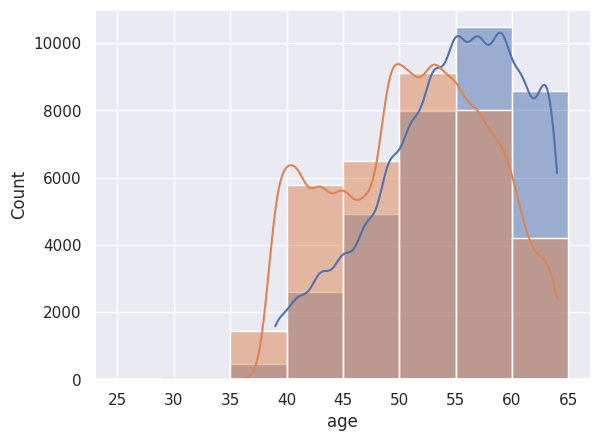

In [58]:
sns.set_theme()
sns.histplot(df[df['cardio'] == 1]['age'], bins=range(25, 66, 5), kde=True) #Blue
sns.histplot(df[df['cardio'] == 0]['age'], bins=range(25, 66, 5), kde=True)  #Orange

**Insight:**

The KDE line smooths out the distribution and gives a visual representation of the underlying probability density function of the age distribution.
It helps you see the overall trend of age distribution.
Interpretation:
Since the bar for the age range 55-60 is the tallest, we can conclude that the highest number of individuals with the cardio condition falls within that age range.
The KDE line shows a peak in a certain age range, it indicates that this age group has a higher density of individuals with the cardio condition,
suggesting potential age-related patterns in cardiovascular health.

Pie charts for visualzing various stages of hypertension across both genders

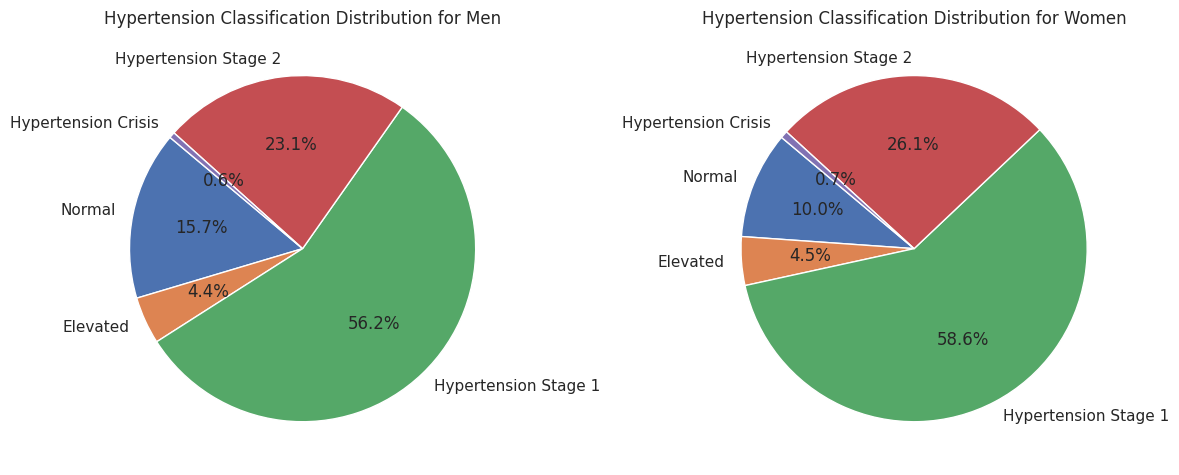

In [59]:
hypertension_counts = df.groupby(['gender', 'Hypertension']).size().unstack()

plt.figure(figsize=(12, 6))

# Creating a pie chart for each gender
for i, gender in enumerate(hypertension_counts.index):
    gender_label = "Women" if gender == 2 else "Men"
    plt.subplot(1, 2, i + 1)
    plt.pie(hypertension_counts.loc[gender], labels=['Normal','Elevated','Hypertension Stage 1','Hypertension Stage 2','Hypertension Crisis'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Hypertension Classification Distribution for {gender_label}')

plt.tight_layout()
plt.show()

**Insight:**


According to the pie charts, we can conclude that women have greater percentage of Hypertension Stage 1 cases as compared to men. They also have more Hypertnesion Stage 2 cases as compared to men. This increases their chances of getting cardiovascular diseases by a narrow margin.

C:\Users\divya\AppData\Local\Temp\ipykernel_976\1328078095.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_distribution = df.groupby(['age_group', 'gender', 'Hypertension']).size().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

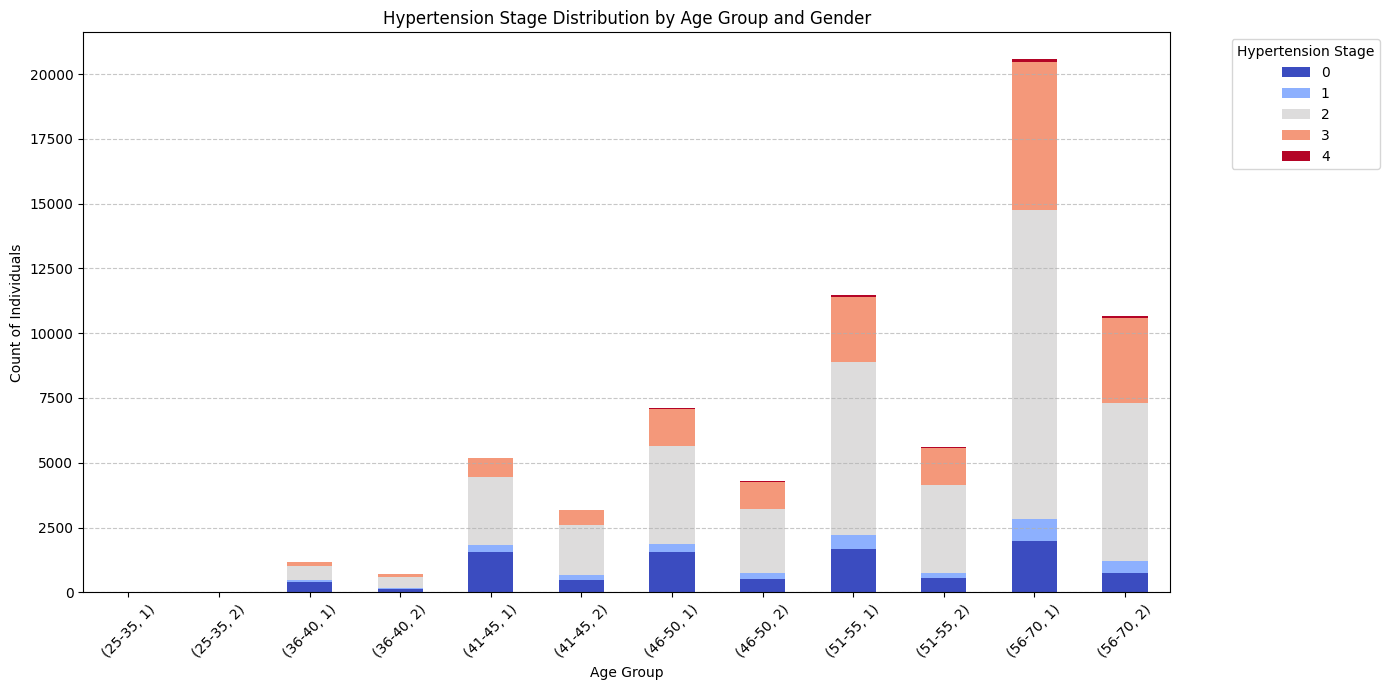

In [19]:
bins = [25, 35, 40, 45, 50, 55, 70]
labels = ['25-35', '36-40', '41-45', '46-50', '51-55', '56-70']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

hypertension_distribution = df.groupby(['age_group', 'gender', 'Hypertension']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
hypertension_distribution.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(14, 7))

plt.title('Hypertension Stage Distribution by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Count of Individuals')
plt.legend(title='Hypertension Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
df.drop(['age_group'],axis=1,inplace=True)

**Insight:**


 The prevalence of hypertension increases with age. This is evident from the increasing height of the stacked bars as we move from younger to older age groups.
The number of individuals in the normal category decreases with age, while the number in the elevated and hypertension stages increases.
In the younger age groups (25-35, 36-40), the majority are still in the normal category.
Starting from the 41-45 age group, we see a significant increase in the number of individuals in the elevated and hypertension stages.
The 56-70 age group has the highest number of individuals in the hypertension stage 2 category.

The increasing prevalence of hypertension with age could be due to various factors like lifestyle changes (e.g., diet, exercise), genetic predisposition, and age-related physiological changes.

**Dectecting the Outlier and Calculating their accuracy score**

Using the describe() to get summary of statistics such as the mean, median, minimum, and maximum values, along with quartiles (25th and 75th percentiles)which could help us spot extreme values that indicate outliers.

Using boxplot visually to get data distribution through quartiles and highlights potential outliers as points outside the "whiskers". This quick visualization helps identify outliers at a glance.

In [61]:
df.describe()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,Hypertension
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,49972.419900,52.803257,1.349571,164.359229,74.205690,128.842157,96.632843,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.556513,1.934429
std,20207.403759,28851.302323,6.762462,0.476838,8.210126,14.395757,153.991179,188.471478,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.091511,0.924615
min,0.000000,0.000000,29.000000,1.000000,55.000000,10.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784,0.000000
25%,17499.750000,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,2.000000
50%,34999.500000,50001.500000,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.374068,2.000000
75%,52499.250000,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.222222,2.000000
max,69999.000000,99999.000000,64.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667,4.000000


<Axes: ylabel='age'>

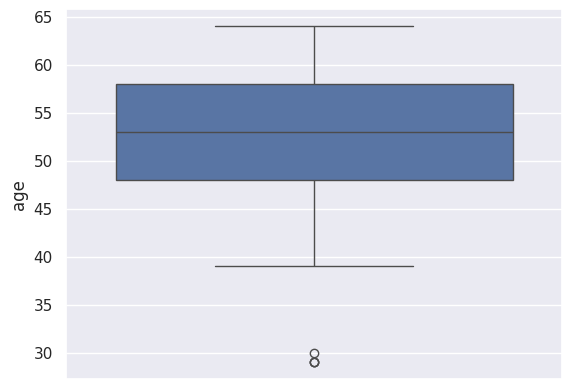

In [62]:
sns.boxplot(df['age'])

<Axes: ylabel='height'>

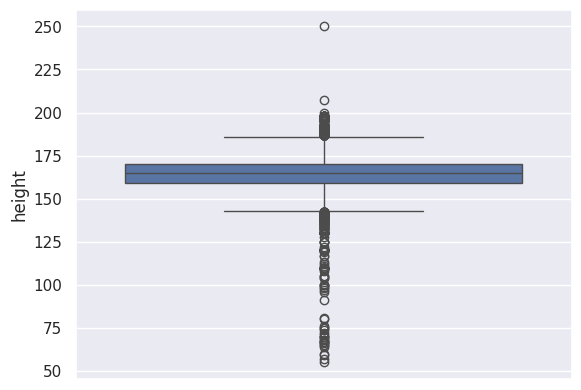

In [63]:
sns.boxplot(df['height'])

<Axes: ylabel='weight'>

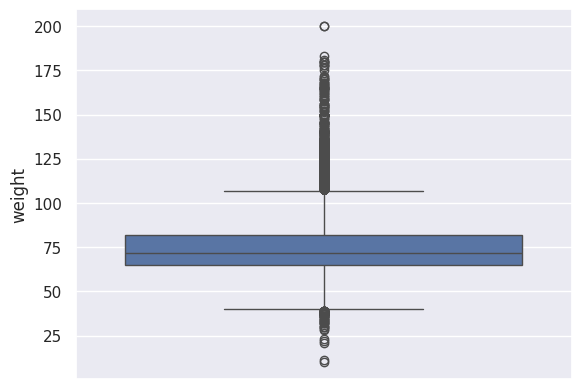

In [64]:
sns.boxplot(df['weight'])

<Axes: ylabel='BMI'>

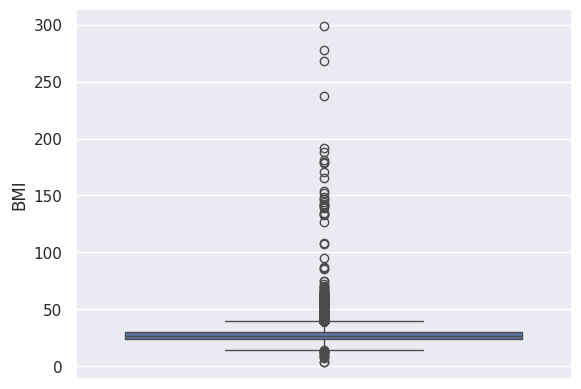

In [65]:
sns.boxplot(df['BMI'])

**Z-scoring Technique:**

z-scores can help identify extreme measurements (e.g., unusually high cholesterol or blood pressure readings) that may skew results if left untreated. By detecting these outliers, we can decide whether to retain, modify, or remove them, depending on their relevance with our analysis.








In [4]:
# Checking for outliers in specific columns using the Z-score method.
column=['age','height','weight','ap_lo','ap_hi','BMI']
# Calculate boundary values (using Z-score):
# For each column, it calculates the mean (average) and standard deviation (a measure of spread).
# The highest and lowest boundaries are based on the Z-score method.
# In a normal distribution, about 99.7% of the data falls within ±3 standard deviations from the mean, so values outside this range are considered outliers.
for cols in column:
    print(f"\n{cols}:")
    # Finding the boundary values
    high=df[cols].mean() + 3*df[cols].std();
    low=df[cols].mean() - 3*df[cols].std()
    print("Highest allowed",high)
    print("Lowest allowed",low)
    # Finding the outliers
    print(df[(df[cols] > high) | (df[cols] < low)])


age:
Highest allowed 73.09064227829062
Lowest allowed 32.51587200742367
       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
6219    6219   8850   29       1     175    59.0    120     80            1   
22343  22343  31922   29       2     175    92.0    100     60            1   
30666  30666  43842   29       1     159    59.0    120     80            1   
55905  55905  79749   30       1     160    59.0    110     70            1   

       gluc  smoke  alco  active  cardio        BMI  
6219      1      0     0       1       0  19.265306  
22343     1      0     0       1       0  30.040816  
30666     1      0     0       1       0  23.337684  
55905     1      0     0       1       0  23.046875  

height:
Highest allowed 188.98960766504268
Lowest allowed 139.72884947781444
       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
224      224    309   59       2      76    55.0    120     80            1   
1027    1027   1432   41 

InterQuartile Technique:

The IQR method is less sensitive to extreme values compared to Z-score. It’s particularly useful for non-normally distributed data because it doesn’t rely on the mean and standard deviation, which can be skewed by outliers.
By applying the IQR method, we can detect and potentially handle outliers without assuming that the data follows a normal distribution. This helps in maintaining the integrity of the analysis, especially when dealing with skewed data.

In [67]:
# IQR is the difference between Q3 and Q1 (IQR = Q3 - Q1). It measures the "spread" of the middle 50% of the data.
# The code calculates and prints the IQR for each column.
column=['age','height','weight','ap_lo','ap_hi','BMI']
for cols in column:
    print(f"\n{cols}:")
    # Finding the IQR
    Q1= df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    print(f"25percentile: {Q1}")
    print(f"75percentile: {Q3}")
    iqr = Q3-Q1
    print(f"IQR: {iqr}")
    upper_limit = Q3 + 1.5 * iqr
    lower_limit = Q1 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    print(df[(df[cols] >= lower_limit) & (df[cols] <= upper_limit)])


age:
25percentile: 48.0
75percentile: 58.0
IQR: 10.0
Upper limit 73.0
Lower limit 33.0
       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
47373  47373  67661   39       1     168    61.0  100.0   80.0            1   
62801  62801  89674   39       2     182    62.0  130.0   60.0            1   
16802  16802  24010   39       1     155    54.0  120.0   80.0            1   
62781  62781  89645   39       2     168    70.0  120.0   80.0            1   
21482  21482  30691   39       2     167    72.0  110.0   70.0            1   
...      ...    ...  ...     ...     ...     ...    ...    ...          ...   
52939  52939  75519   64       1     162   110.0  140.0   90.0            3   
16318  16318  23314   64       1     166    68.0  140.0   90.0            3   
61161  61161  87316   64       1     152    70.0  170.0   80.0            1   
52740  52740  75241   64       1     170    76.0  120.0   80.0            1   
27304  27304  39043   64       1     160   

In [5]:
#Checking the accuracy score after removing the outlier using z-score
column=['weight','ap_lo','ap_hi']
zscore_df=df
#Filter Out Outliers, keeping only the rows where values in the column are within the high and low bounds (i.e., not outliers).
# The resulting dataset, new_df, has outliers removed for the selected columns.
for cols in column:
    # Finding the boundary values
    high=zscore_df[cols].mean() + 3*zscore_df[cols].std();
    low=zscore_df[cols].mean() - 3*zscore_df[cols].std()
    # Triming the outliers
    zscore_df = zscore_df[(zscore_df[cols] < high) & (zscore_df[cols] > low)]
print(zscore_df.head(5))

# Creating two separate train-test splits for two versions of the dataset:
# Original Dataset (df):Splits df into X_train, X_test, y_train, and y_test, where X contains features (everything except the cardio column) and y is the target variable (cardio column).
# Outlier-Removed Dataset (zscore_df):Splits new_df into X_train_scaled, X_test_scaled, y_train_scaled, and y_test_scaled, following the same format as the original dataset split.
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1),
                                                    df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)
X_train_scaled , X_test_scaled,y_train_scaled,y_test_scaled =train_test_split(zscore_df.drop('cardio', axis=1),
                                                    zscore_df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)
lr = LogisticRegression()
lr_scaled = LogisticRegression()
# Fit the models
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluate if removing outliers (using Z-scoring) improves the model’s accuracy in predicting the target variable (cardio).
print("Actual Accuracy:", accuracy_score(y_test, y_pred))
print("Zscoring Accuracy:", accuracy_score(y_test_scaled, y_pred_scaled))

   index  id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0      0   0   50       2     168    62.0    110     80            1     1   
1      1   1   55       1     156    85.0    140     90            3     1   
2      2   2   51       1     165    64.0    130     70            3     1   
3      3   3   48       2     169    82.0    150    100            1     1   
4      4   4   47       1     156    56.0    100     60            1     1   

   smoke  alco  active  cardio        BMI  
0      0     0       1       0  21.967120  
1      0     0       1       1  34.927679  
2      0     0       0       1  23.507805  
3      0     0       1       1  28.710479  
4      0     0       0       0  23.011177  


c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual Accuracy: 0.7012857142857143
Zscoring Accuracy: 0.704931226221832


c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



**Insight:**

This slight increase in accuracy indicate that the model generalize better on the test data. By filtering out extreme values that could distort the analysis, the model can focus on patterns that are more representative of the majority of data points.

In [21]:
#Checking the accuracy score after removing the outlier using IQR
column=['ap_lo','ap_hi']
IQR_df=df
for cols in column:
    # Finding the IQR
    Q1= IQR_df[cols].quantile(0.25)
    Q3 = IQR_df[cols].quantile(0.75)
    iqr = Q3-Q1
    upper_limit = Q3 + 1.5 * iqr
    lower_limit = Q1 - 1.5 * iqr
    IQR_df=IQR_df[(IQR_df[cols] >= lower_limit) & (IQR_df[cols] <= upper_limit)]
# It splits both the original data (df) and the cleaned data (IQR_df) into training and testing sets.
# X_train and y_train are the training features and labels from the original data, while X_train_scaled and y_train_scaled are from the cleaned data.
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1),
                                                    df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)
X_train_scaled , X_test_scaled,y_train_scaled,y_test_scaled =train_test_split(IQR_df.drop('cardio', axis=1),
                                                    IQR_df['cardio'],
                                                    test_size=0.2,
                                                    random_state=42)
lr = LogisticRegression()
lr_scaled = LogisticRegression()
# Fit the models
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluate accuracy
print("Actual Accuracy:", accuracy_score(y_test, y_pred))
print("IQR Accuracy:", accuracy_score(y_test_scaled, y_pred_scaled))

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual Accuracy: 0.7017142857142857
IQR Accuracy: 0.6909541895977056


c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The Interquartile Range (IQR) technique shows a slight improvement over the actual accuracy, with an increase of about 0.0132%. This suggests that using IQR for handling outliers or data scaling has had a positive effect on the model's performance.

**Comparison:**

Both IQR and Zscoring techniques improve upon the actual accuracy, but Zscoring shows a more significant boost.
IQR provides a modest improvement, indicating it may be effective for certain types of data distributions or outlier management.Zscoring, however, appears to be more effective in optimizing the model's performance, likely due to its ability to standardize features, making them comparable and improving convergence during model training.

Both techniques have merit, but Zscoring offers a more substantial enhancement to the model's accuracy

**Doing Standard Scaling:**

It normalizes the features of a dataset, ensuring they have a mean of zero and a standard deviation of one. This process helps eliminate bias caused by varying scales of features, allowing algorithms to converge more effectively and improving model performance.Overall, promoting more reliable and efficient training of machine learning models.

In [7]:
from sklearn.preprocessing import StandardScaler
#Scaling using dataset with outliers
# The train_test_split function divides the dataset (df) into two parts:
# Training Set (X_train, y_train) and Testing Set (X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1),df['cardio'],test_size=0.2,random_state=42)
X_train.shape, X_test.shape
scaler = StandardScaler() #creates an object that will help in scaling the data.

# scaler.fit() learns the mean and standard deviation from the training set.
scaler.fit(X_train)

# transform train and test sets then apply this scaling to both the training and testing sets, transforming them into standardized data.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lr = LogisticRegression()
lr_scaled = LogisticRegression()
# Fit the models
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluate accuracy
print("Actual Accuracy:", accuracy_score(y_test, y_pred))
print("Scaled Accuracy without outlier:", accuracy_score(y_test, y_pred_scaled))

Actual Accuracy: 0.7012857142857143
Scaled Accuracy without outlier: 0.7224285714285714


c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


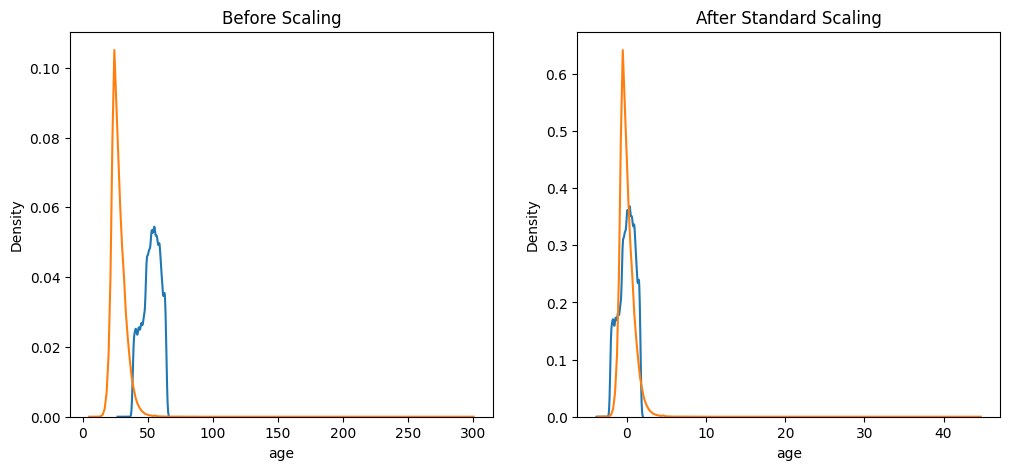

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['age'], ax=ax1)
sns.kdeplot(X_train['BMI'], ax=ax1)

# after scaling
ax2.set_title('After Standard Scaling')
sns.kdeplot(X_train_scaled['age'], ax=ax2)
sns.kdeplot(X_train_scaled['BMI'], ax=ax2)
plt.show()

**Insight:**

In the Before Scaling plot, age and BMI are shown in their original units, where they may have vastly different scales. For instance, age might range between 25-65, while BMI might have a much smaller range. This difference in scale can affect how algorithms interpret these features.

In the After Standard Scaling plot, the values are normalized, and both age and BMI have a mean close to 0 with a standard deviation of 1. This standardization makes both distributions comparable in terms of scale without changing the original shape or relative density of the data points.

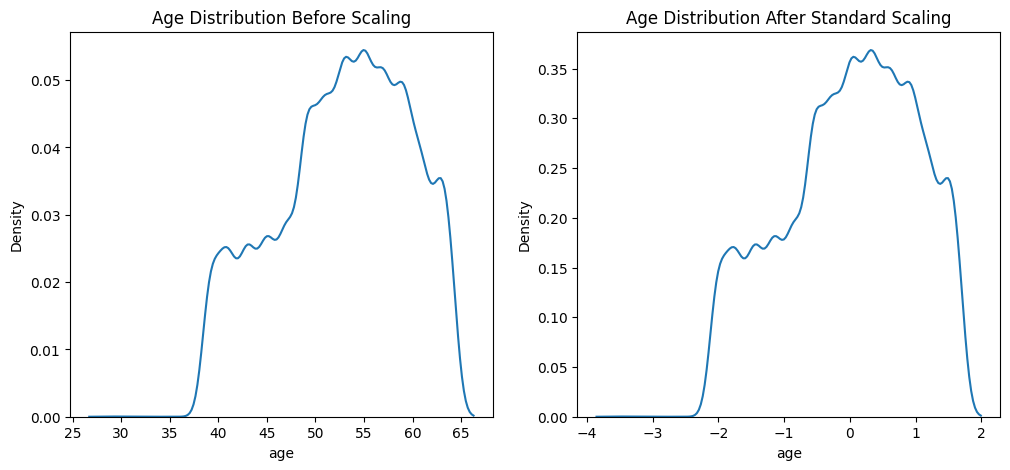

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Age Distribution Before Scaling')
sns.kdeplot(X_train['age'], ax=ax1)

# after scaling
ax2.set_title('Age Distribution After Standard Scaling')
sns.kdeplot(X_train_scaled['age'], ax=ax2)
plt.show()

Before Scaling: The age distribution is in its original form, with values spread out over a large range. This shows the natural skew and concentration of values in the data.

After Scaling: The distribution is transformed to have a mean of 0 and unit variance, while preserving its shape. This scaled distribution facilitates machine learning models by making the feature comparable in scale to other features.

 Although the scale has changed, the overall shape and pattern of the distribution remain similar. This is important because it shows that scaling does not distort the relative relationships between data points. Instead, it only normalizes the values so that they are easier for the model to work with, making the distribution comparable to other scaled features.

In [10]:
#Scaling using dataset without outliers(weight,ap_lo,ap_hi)
X_train, X_test, y_train, y_test = train_test_split(zscore_df.drop('cardio', axis=1),zscore_df['cardio'],test_size=0.2,random_state=42)
X_train.shape, X_test.shape
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
np.round(X_train.describe(), 1)
np.round(X_train_scaled.describe(), 1)

lr = LogisticRegression()
lr_scaled = LogisticRegression()
# Fit the models
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluate accuracy
print("Actual Accuracy without outlier:", accuracy_score(y_test, y_pred))
print("Scaled Accuracy without outlier:", accuracy_score(y_test, y_pred_scaled))

Actual Accuracy without outlier: 0.704931226221832
Scaled Accuracy without outlier: 0.7295873573309921


c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Min-Max Scaling Method:**



It is used to scale the data so as to bring them to a particular range ie [0,1] for consistency in model. It makes use of the LogisticRegression Model to make predictions. Another way of scaling data is Absolute Maximum Scaling Method which brings the dataset to the range [-1,1]. It is used when the dataset has negative and positive values. Since we have already handled negative values in the previous sections, there would be no point in applying this method as it would bring the positive values to the range [0,1] which is already achieved by Min-Max Scaling Method.

In [25]:
#Checking the accuracy score after removing the outlier using z-score
column=['weight','ap_lo','ap_hi']
minmax_df=df
#Filter Out Outliers, keeping only the rows where values in the column are within the high and low bounds (i.e., not outliers).
# The resulting dataset, new_df, has outliers removed for the selected columns.
for cols in column:
    # Finding the boundary values
    high=minmax_df[cols].mean() + 3*minmax_df[cols].std();
    low=minmax_df[cols].mean() - 3*minmax_df[cols].std()
    # Triming the outliers
    minmax_df = minmax_df[(minmax_df[cols] < high) & (minmax_df[cols] > low)]
#cardio is the target (dependent) variable so removing that column while maximum absolute scaling
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), df['cardio'], test_size=0.2, random_state=42)

min_max_scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = min_max_scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = min_max_scaler.transform(X_test)

# Converting the scaled data back to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lr = LogisticRegression()
lr_scaled = LogisticRegression()

# Fiting the model on the original and scaled data
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train)

#making predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluating the accuracy of both models
print("Actual Accuracy without scaling:", accuracy_score(y_test, y_pred))
print("Accuracy after Min-Max scaling:", accuracy_score(y_test, y_pred_scaled))

X_train, X_test, y_train, y_test = train_test_split(minmax_df.drop('cardio', axis=1), minmax_df['cardio'], test_size=0.2, random_state=42)

min_max_scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = min_max_scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = min_max_scaler.transform(X_test)

# Converting the scaled data back to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

lr = LogisticRegression()
lr_scaled = LogisticRegression()

# Fiting the model on the original and scaled data
lr.fit(X_train, y_train)
lr_scaled.fit(X_train_scaled, y_train)

#making predictions
y_pred = lr.predict(X_test)
y_pred_scaled = lr_scaled.predict(X_test_scaled)

# Evaluating the accuracy of both models
print("Actual Accuracy without scaling without outliers:", accuracy_score(y_test, y_pred))
print("Accuracy after Min-Max scaling without outliers:", accuracy_score(y_test, y_pred_scaled))

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual Accuracy without scaling: 0.7017142857142857
Accuracy after Min-Max scaling: 0.6968571428571428


c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual Accuracy without scaling without outliers: 0.7047117354404449
Accuracy after Min-Max scaling without outliers: 0.7244659057652912


**Graphs of features-height and weight after min-max scaling**

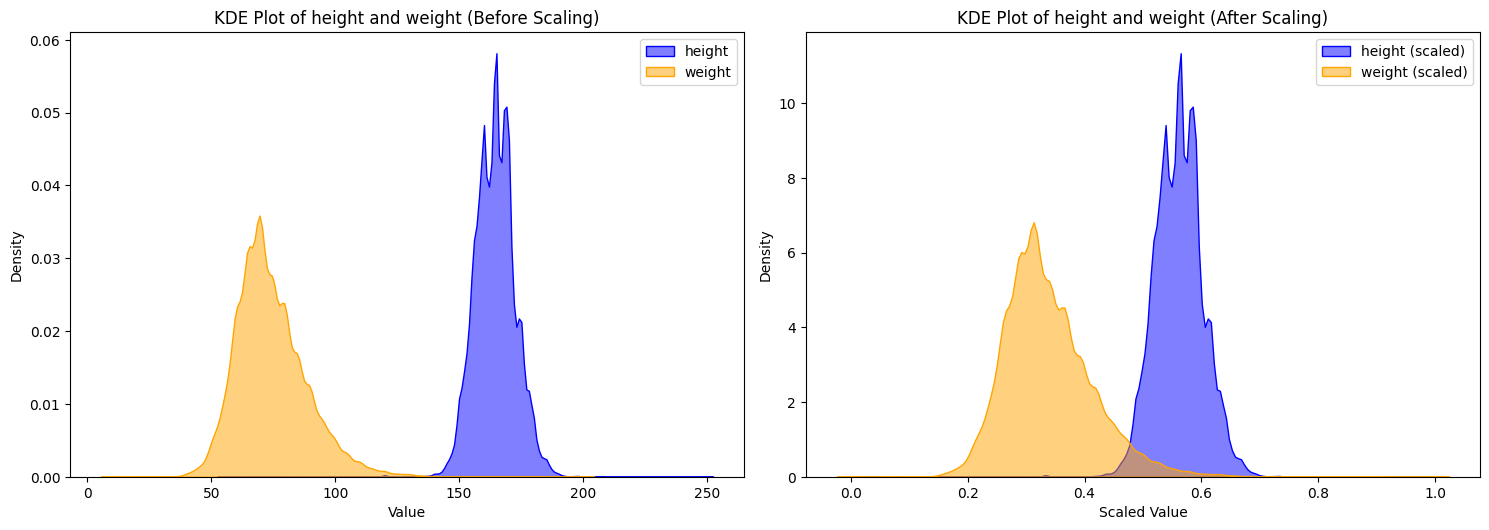

In [26]:
features = df[['height', 'weight']]

# Scale the features-height and weight using Min-Max Scaling
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=['height', 'weight'])

#plot
plt.figure(figsize=(15, 10))

#using KDE plot for original data
plt.subplot(2, 2, 1)
sns.kdeplot(features['height'], label='height', fill=True, color='blue', alpha=0.5)
sns.kdeplot(features['weight'], label='weight', fill=True, color='orange', alpha=0.5)
plt.title('KDE Plot of height and weight (Before Scaling)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

#using KDE plot for scaled data
plt.subplot(2, 2, 2)
sns.kdeplot(features_scaled_df['height'], label='height (scaled)', fill=True, color='blue', alpha=0.5)
sns.kdeplot(features_scaled_df['weight'], label='weight (scaled)', fill=True, color='orange', alpha=0.5)
plt.title('KDE Plot of height and weight (After Scaling)')
plt.xlabel('Scaled Value')
plt.ylabel('Density')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

**Inference:**


**Before Scaling:**



Height(unscaled): The height distribution appears to be roughly normal, with a peak around 170-180 units and a relatively narrow spread. This suggests that most individuals in the dataset have heights within this range, with fewer individuals having significantly taller or shorter heights.
Weight(unscaled):
The weight distribution is skewed to the right, with a longer tail towards higher values. This indicates that while there are many individuals with lower weights, there are also a significant number of individuals with much higher weights.

**After Scaling:**

Height (scaled):
The scaled height distribution now appears more symmetrical, with a peak around 0.6-0.7. This suggests that the scaling process has transformed the height values to a more uniform scale.
Weight (scaled):
The scaled weight distribution is also more symmetrical than before, with a peak around 0.4-0.5. The right tail has been compressed, suggesting that the scaling process has reduced the impact of extreme weight values.

**Conclusion:**
Although min-max scaling was achieved successfully, the accuracy evaluated after scaling was reduced. We can conclude that z-scaling is the most appropriate way of normalizing our dataset as the accuracy is better.

Applying Feature Reduction Technique:



**PCA:**


Principal Component Analysis (PCA) is a technique for reducing the number of features in a dataset while preserving as much of its original information as possible. It does this by identifying patterns in the data, specifically the directions (or "principal components") along which the data varies the most. These principal components are essentially new axes that capture the majority of the dataset's variance in a simplified form. By projecting the data onto just a few of these principal components, PCA reduces the complexity of the data, discarding less important information and keeping only the most essential parts.

In [76]:
# Applying PCA on Standard Scaled data
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
np.round(X_train.describe(), 1)
np.round(X_train_scaled.describe(), 1)

# Performing PCA on one of the sets
pca = PCA(n_components = 5)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance for training data: {explained_variance.sum()}")

X_test_scaled_pca = pca.fit_transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance for testing data: {explained_variance.sum()}")

# Perfoming Logistic regression on set with PCA and without PCA
lr_test_scaled = LogisticRegression()
lr_test_scaled_pca = LogisticRegression()

lr_test_scaled.fit(X_train_scaled, y_train)
lr_test_scaled_pca.fit(X_train_scaled_pca, y_train)

#making predictions
y_pred_scaled = lr_test_scaled.predict(X_test_scaled)
y_pred_scaled_pca  = lr_test_scaled_pca.predict(X_test_scaled_pca)

# Evaluating the accuracy of both models
print("Actual Accuracy Z-Scaled with PCA:", accuracy_score(y_test, y_pred_scaled_pca))
print("Actual Accuracy Z-Scaled without PCA:",accuracy_score(y_test, y_pred_scaled))

Explained variance for training data: 0.6412594164490382
Explained variance for testing data: 0.6447296859991831
Actual Accuracy Z-Scaled with PCA: 0.7201492537313433
Actual Accuracy Z-Scaled without PCA: 0.7254170324846356


**Inference**

**PCA on Stardard Scaler Data**

PCA on Z-Scale data will provide better max accuracy at 72% but the explained variance is very low at 64. We have to provide 7 components to get the maximum accuracy and upto 10 components to get an acceptable explained variance value, Which is a lot more than the ideal maximum of 3 components

In [77]:
# Applying PCA on Min-Max Scaled data
min_max_scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = min_max_scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = min_max_scaler.transform(X_test)

# Converting the scaled data back to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Performing PCA on one of the sets
pca = PCA(n_components = 8)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance for training data: {explained_variance.sum()}")

X_test_scaled_pca = pca.fit_transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance for testing data: {explained_variance.sum()}")

# Perfoming Logistic regression on set with PCA and without PCA
lr_test_scaled = LogisticRegression()
lr_test_scaled_pca = LogisticRegression()

lr_test_scaled.fit(X_train_scaled, y_train)
lr_test_scaled_pca.fit(X_train_scaled_pca, y_train)

#making predictions
y_pred_scaled = lr_test_scaled.predict(X_test_scaled)
y_pred_scaled_pca  = lr_test_scaled_pca.predict(X_test_scaled_pca)

# Evaluating the accuracy of both models
print("Actual Accuracy Z-Scaled with PCA:", accuracy_score(y_test, y_pred_scaled_pca))
print("Actual Accuracy Z-Scaled without PCA:",accuracy_score(y_test, y_pred_scaled))

Explained variance for training data: 0.9424257941118594
Explained variance for testing data: 0.9428420300783802
Actual Accuracy Z-Scaled with PCA: 0.7007609013754755
Actual Accuracy Z-Scaled without PCA: 0.7246853965466784


**Inference**


**PCA on Min-Max Scaled data**

PCA on Min-Max Scaled data will provide a sufficient Explained variance at 8 components but its accuracy is quite low at 70%. there is a noticable dip in accuracy compared to without PCA. we also require 8 components here for ideal results, which is more than the ideal maximum of 3

**Result**

PCA is not a good way for feature reduction on this dataset as we need a large amount of features to get acceptable values of accuracy or total explained variance

**SVD:**

Singular Value Decomposition (SVD) is a powerful linear algebra technique used for dimensionality reduction. It breaks down a matrix into three components (U, Σ, V), which allows us to understand and keep the most significant patterns in the data while discarding noise or less critical information.Models on SVD data often generalize better and may perform well in terms of accuracy by reducing overfitting risks associated with many redundant or noisy features.

First Combining the X_train_scaled and X_test_scaled into one DataFrame

In [78]:
StdScalar_withoutOutlier = pd.concat([X_train_scaled, X_test_scaled], ignore_index=True)
print(StdScalar_withoutOutlier.describe())

              index            id           age        gender        height  \
count  68339.000000  68339.000000  68339.000000  68339.000000  68339.000000   
mean       0.499870      0.499598      0.679836      0.348044      0.560657   
std        0.288635      0.288468      0.193285      0.476354      0.041762   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.249786      0.249870      0.542857      0.000000      0.533333   
50%        0.499857      0.499840      0.685714      0.000000      0.564103   
75%        0.749543      0.748380      0.828571      1.000000      0.589744   
max        1.000014      1.000010      1.000000      1.000000      1.000000   

             weight         ap_hi         ap_lo   cholesterol          gluc  \
count  68339.000000  68339.000000  68339.000000  68339.000000  68339.000000   
mean       0.489232      0.302509      0.135024      0.180761      0.111649   
std        0.155549      0.044882      0.016979    

In [79]:
 # SVD for dimensionality reduction on Scaled Dataset
from sklearn.decomposition import TruncatedSVD
# Transforming the data by projecting it onto the two singular vectors
svd = TruncatedSVD(n_components=2)
reduced_data = svd.fit_transform(StdScalar_withoutOutlier )
print(f"Component=2:",end=' ')
print(svd.explained_variance_ratio_)


# Transforming the data by projecting it onto the five singular vectors
svd = TruncatedSVD(n_components=5)
reduced_data = svd.fit_transform(StdScalar_withoutOutlier )
print(f"Component=5:",end=' ')
print(svd.explained_variance_ratio_)

# Transforming the data by projecting it onto the ten singular vectors
svd = TruncatedSVD(n_components=10)
reduced_data = svd.fit_transform(StdScalar_withoutOutlier )
print(f"Component=10:",end=' ')
print(svd.explained_variance_ratio_)

Component=2: [0.11383137 0.23670077]
Component=5: [0.11383137 0.23670077 0.16309814 0.14990038 0.09584938]
Component=10: [0.11383137 0.23670077 0.16309814 0.14990038 0.09584938 0.07498003
 0.05147799 0.03944927 0.03853375 0.02573092]


With only 2 components, the explained variance is around 32.43% . This suggests that these two components capture a limited amount of the total information, meaning that reducing the data to 2 components could lose significant detail from the original features.

When the number of components increases to 5, the cumulative explained variance rises to about 64.2% (adding the first five values). This level of variance suggests a better approximation of the dataset, though it's still below the threshold (typically 80-90%) that would indicate strong retention of information with minimal loss.

By increasing the components to 10, the explained variance captures around 92.3% of the variability in the dataset. This high explained variance indicates that 10 components retain most of the important information in the original data, allowing for dimensionality reduction while preserving the structure.

In [80]:
# Checking the accuracy of SVD with 10 components with scaled data
svd = TruncatedSVD(n_components=10)
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd = svd.transform(X_test_scaled)

#Train the models
model_scaled = LogisticRegression()
model_svd = LogisticRegression()

model_scaled.fit(X_train_scaled, y_train)
model_svd.fit(X_train_svd, y_train)

# Evaluate the accuracy on both datasets
print("Accuracy on scaled dataset:", model_scaled.score(X_test_scaled, y_test))
print("Accuracy on SVD dataset:", model_svd.score(X_test_svd, y_test))

Accuracy on scaled dataset: 0.7246853965466784
Accuracy on SVD dataset: 0.6943956687152473


The marginal difference in accuracy suggests that the SVD-reduced dataset retains a significant amount of information, but it does not quite capture as much predictive power as the original scaled features. This might be expected, especially if the most informative features are spread out across multiple components.

The SVD dataset offers dimensionality reduction, which can be beneficial in terms of model complexity and computational efficiency. However, in this case, it seems that using the full set of scaled features provides slightly better performance.

**LDA**<br>
Linear Discriminant Analysis is a feature reduction technique used in various domains for its ability to handle classification tasks effectively while reducing dimensionality. It emphasizes maximizing class separability, making it an excellent choice for scenarios where understanding the relationship between different classes is crucial.<br>
In our dataset, the target variable is cardio which has 2 unique values-0 and 1. Hence, n_components=1 i.e(unique-1)

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train_scaled, y_train)

# Transform the training and test data
X_train_lda = lda.transform(X_train_scaled)
X_test_lda = lda.transform(X_test_scaled)

# Fit Logistic Regression on LDA transformed data for finding the accuracy
lr_lda = LogisticRegression()
lr_lda.fit(X_train_lda, y_train)

# Making predictions with the LDA model
y_pred_lda = lr_lda.predict(X_test_lda)

# Calculating accuracy for LDA model
lda_accuracy = accuracy_score(y_test, y_pred_lda)

# Explained variance ratio for the LDA components
explained_variance = lda.explained_variance_ratio_

print("Explained Variance Ratios for LDA components:", explained_variance)
print("LDA Model Accuracy:", lda_accuracy)
lda = LinearDiscriminantAnalysis(n_components=1)


Explained Variance Ratios for LDA components: [1.]
LDA Model Accuracy: 0.7239537606087211


**Inference:**<br>
Explained variance-It is a statistical measure used to quantify the amount of variability in a dataset that can be attributed to a particular component or feature.
The explained variance will be 1 always because n_components=1.<br>
The accuracy, although better than the SVD, is similar to the accuracy of the PCA Model. It means that the model correctly classified about 72.45% of the instances in the test dataset.

**Conclusion:**<br>
After using various scaling techniques such as zscore method, outlier removal method and min-max scaling method and feature reduction techniques such as PCA, SVD and LDA, we come to the conclusion that we do not require feature reduction techniques on our dataset as they only decrease the accuracy of the model. We will be sticking the StandardScaling done on zscore dataset.

**Polynomial Regression :**<br>


Polynomial regression is a form of regression analysis where the relationship between the independent variable (ap_lo,ap_hi, etc) and the dependent variable (cardio) is modeled as an nth degree polynomial. This technique is particularly useful when the relationship between the variables is not linear. <br>
In simple linear regression, we fit a straight line to the data points.
In polynomial regression, we fit a curve to the data points. The degree of the polynomial determines the shape of the curve. A higher degree polynomial can fit more complex curves.   



In [12]:
print(df.head(4))#Displaying the first few rows to know what features to take
degree=2
poly = PolynomialFeatures(degree=degree, include_bias=False)  
X = df[['age','gender','height','weight','ap_hi', 'ap_lo','cholesterol','gluc','smoke','alco','active']]#taking only the non-derived cols
y = df['cardio']# target variable is cardio
X_poly = poly.fit_transform(X)  #Transforming the preprocessed features

#Fitting Linear Regression Model with Polynomial Features(degree=2)
model = LinearRegression()
model.fit(X_train, y_train)

#Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#Evaluating the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Polynomial Degree: {degree}")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")

   index  id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0      0   0   50       2     168    62.0    110     80            1     1   
1      1   1   55       1     156    85.0    140     90            3     1   
2      2   2   51       1     165    64.0    130     70            3     1   
3      3   3   48       2     169    82.0    150    100            1     1   

   smoke  alco  active  cardio        BMI  
0      0     0       1       0  21.967120  
1      0     0       1       1  34.927679  
2      0     0       0       1  23.507805  
3      0     0       1       1  28.710479  
Polynomial Degree: 2
Training MSE: 0.22046456294395178
Test MSE: 0.2180805925758415
Training R²: 0.11814052329438374
Test R²: 0.12767506612948165


Increasing degree to 5 and keeping the columns same

In [29]:
degree=5
poly = PolynomialFeatures(degree=degree, include_bias=False)  
X = df[['age','gender','height','weight','ap_hi', 'ap_lo','cholesterol','gluc','smoke','alco','active']]#taking only the non-derived cols
y = df['cardio']# target variable is cardio
X_poly = poly.fit_transform(X)  #Transforming the preprocessed features

#Fitting Linear Regression Model with Polynomial Features(degree=2)
model = LinearRegression()
model.fit(X_train, y_train)

#Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#Evaluating the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Polynomial Degree: {degree}")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")


Polynomial Degree: 5
Training MSE: 0.22095592499241806
Test MSE: 0.21880135275459067
Training R²: 0.11617507237044711
Test R²: 0.1247920169418506


Keeping degree=2 and decreasing the columns

Polynomial Degree: 2
Training MSE: 0.20985321692581355
Test MSE: 0.21377086685935773
Training R²: 0.16058596632495648
Test R²: 0.14491401965683115


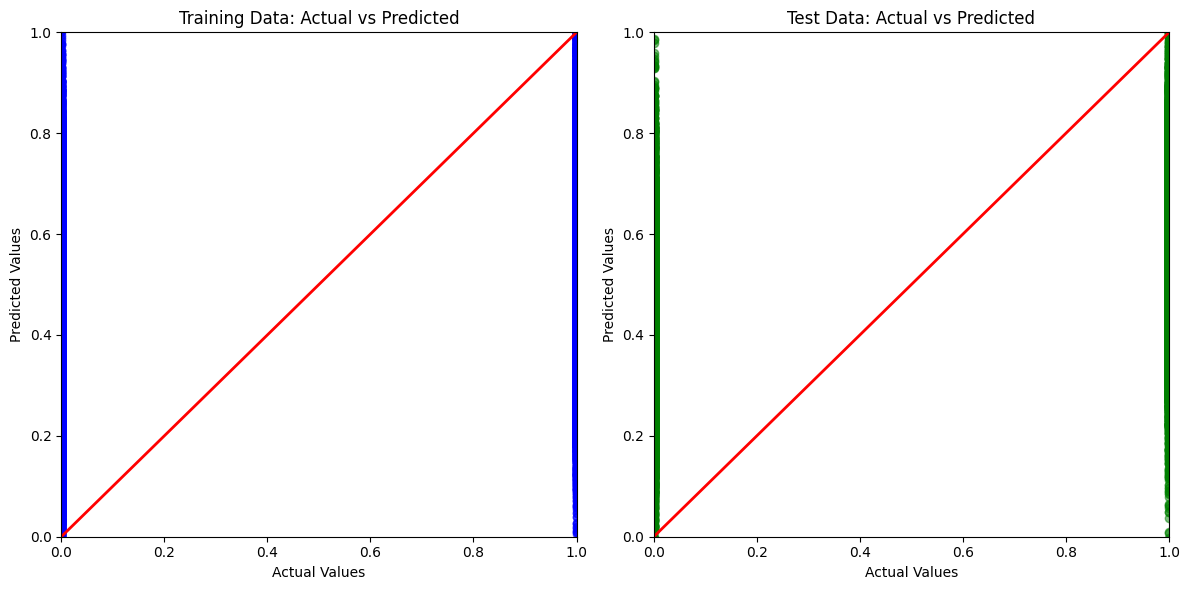

In [30]:
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)  

# Selecting features
X = df[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol']]
y = df['cardio']  # Target variable

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transforming features
X_poly_train = poly.fit_transform(X_train)  # Fit and transform training data
X_poly_test = poly.transform(X_test)  # Transform test data

# Fitting Linear Regression Model with Polynomial Features
model = LinearRegression()
model.fit(X_poly_train, y_train) # Fit using the transformed training data

# Predictions
y_pred_train = model.predict(X_poly_train)  # Use transformed training data
y_pred_test = model.predict(X_poly_test)  # Use transformed test data

# Evaluating the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Polynomial Degree: {degree}")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")

# Plotting predictions vs actual values
plt.figure(figsize=(12, 6))

# Plot for training data
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)  # Diagonal line
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([y_train.min(), y_train.max()])
plt.ylim([y_train.min(), y_train.max()])

# Plot for test data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Diagonal line
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([y_test.min(), y_test.max()])
plt.ylim([y_test.min(), y_test.max()])

plt.tight_layout()
plt.show()

**Inference:**<br>
Overall, the graph suggests that the polynomial regression model of degree 2 might underfit the data. This means that the model is not complex enough to capture the underlying relationship between the features and the target variable. We have tried increasing the degree of the polynomial to see if it improves the model's performance. However, increasing the polynomial degree too much can lead to overfitting. 

**Conclusion:**
On trying various combinations of degree=2 and feature columns, we get approximately the same value for MSE on training and testing ie. around 0.20-0.22. r^2 value is comparatively better when degree=2 and only some of the feature columns are taken into account. However, low r^2 values in polynomial regression suggest that the model isn't effectively capturing the variance in the target variable.<br>
Overall, the MSE and r^2 values are remaining almost the same even if we change the degree from 2 to 5. The above graph and the variation of r^2 and MSE values for different degrees clearly indicates underfitting. 

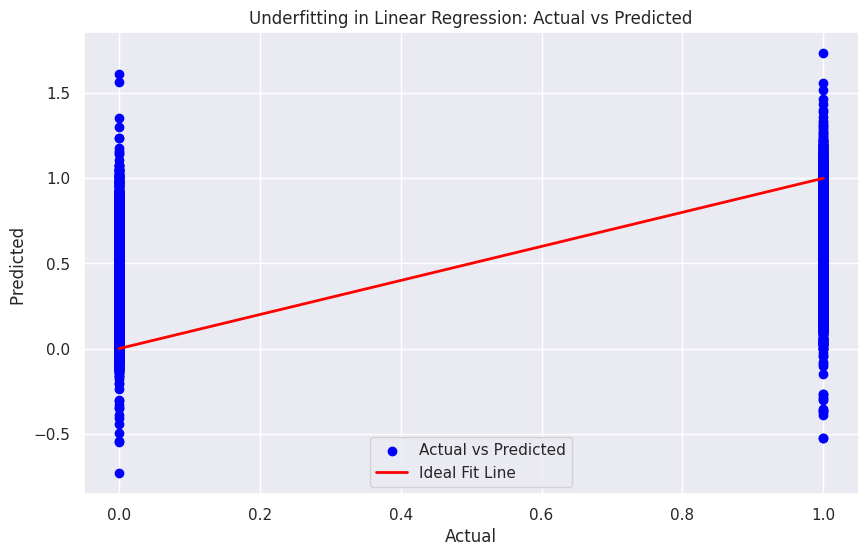

Mean Squared Error Train (Multiple Linear Regression):0.19544523413046672
Mean Squared Error Test (Multiple Linear Regression): 0.19445584903988994
r2 train score is 0.21801414958678345
r2 test score is 0.22212981859480385
Train Bias: 0.0, Variance: 0.05448925512811718
Test Bias: -0.004581842830304883, Variance: 0.05389585499897635


In [84]:
reg = LinearRegression()
reg.fit(X_train_scaled,y_train)
LinearRegression()
y_train_pred = reg.predict(X_train_scaled)
y_test_pred = reg.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color='red', linewidth=2, label='Ideal Fit Line')
plt.title('Underfitting in Linear Regression: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted ')
plt.legend()
plt.show()

def calculate_bias_variance(y_true, y_pred):
  bias = np.mean(y_pred) - np.mean(y_true)
  variance = np.var(y_pred)
  return bias, variance

# Calculate Mean Squared Error (MSE) for both the training and testing sets
mse_train= mean_squared_error(y_train, y_train_pred)
mse_test= mean_squared_error(y_test, y_test_pred)
r2_train= r2_score(y_train, y_train_pred)
r2_test= r2_score(y_test, y_test_pred)
print(f'Mean Squared Error Train (Multiple Linear Regression):{mse_train}')
print(f'Mean Squared Error Test (Multiple Linear Regression): {mse_test}')
print('r2 train score is', r2_train)
print('r2 test score is', r2_test)
bias_train, variance_train = calculate_bias_variance(y_train,y_train_pred)
bias_test, variance_test = calculate_bias_variance(y_test,y_test_pred)
print(f"Train Bias: {bias_train}, Variance: {variance_train}")
print(f"Test Bias: {bias_test}, Variance: {variance_test}")


Based on the  metrics,

Mean Squared Error (MSE):Both training and test MSE values are quite close, indicating that the model is not overfitting, as it's not performing significantly worse on unseen data.

R-squared (R²) Scores:The R² values are relatively low, which suggests that the model is not capturing much of the variance in the data. This indicate underfitting, where the model is too simplistic to capture the relationships in the data effectively.

Bias and Variance:These bias and variance values are low, showing that the model's predictions are relatively stable but not very accurate. This is consistent with underfitting, as the model does not have enough complexity to capture the underlying patterns.

In conclusion, this model appears to be underfitting the data due to the low R² values and balanced error metrics. To improve performance, consider adding more features, using a more complex model, or trying polynomial features to capture non-linear relationships.